COVID-19 detection using Chest x-ray images

In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Covid prediction'

Mounted at /content/drive
/content/drive/My Drive/Covid prediction


Importing all dependencies

In [12]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

Defining few parameters

In [13]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data/chest/Chest_COVID'
noncovid_path = 'data/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [14]:
covid_files

['data/chest/Chest_COVID/85E52EB3-56E9-4D67-82DA-DEA247C82886.jpeg',
 'data/chest/Chest_COVID/53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg.jpg',
 'data/chest/Chest_COVID/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg',
 'data/chest/Chest_COVID/6CB4EFC6-68FA-4CD5-940C-BEFA8DAFE9A7.jpeg',
 'data/chest/Chest_COVID/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png',
 'data/chest/Chest_COVID/F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg',
 'data/chest/Chest_COVID/MERS-CoV-1-s2.0-S0378603X1500248X-gr4e.jpg',
 'data/chest/Chest_COVID/cavitating-pneumonia-4-day28-L.png',
 'data/chest/Chest_COVID/1-s2.0-S1684118220300682-main.pdf-002-a2.png.jpg',
 'data/chest/Chest_COVID/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'data/chest/Chest_COVID/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg.jpg',
 'data/chest/Chest_COVID/16669_1_1.jpeg',
 'data/chest/Chest_COVID/B2D20576-00B7-4519-A415-72DE29C90C34.jpeg',
 'data/chest/Chest_COVID/44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg',
 'da

In [15]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

In [16]:
covid_images

[array([[[253, 253, 253],
         [  1,   1,   1],
         [  0,   0,   0],
         ...,
         [ 70,  70,  70],
         [245, 245, 245],
         [254, 254, 254]],
 
        [[ 41,  41,  41],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 51,  51,  51],
         [110, 110, 110],
         [254, 254, 254]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 48,  48,  48],
         [ 51,  51,  51],
         [255, 255, 255]],
 
        ...,
 
        [[210, 210, 210],
         [217, 217, 217],
         [211, 211, 211],
         ...,
         [  0,   0,   0],
         [  1,   1,   1],
         [254, 254, 254]],
 
        [[205, 205, 205],
         [221, 221, 221],
         [217, 217, 217],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [253, 253, 253]],
 
        [[237, 237, 237],
         [213, 213, 213],
         [221, 221, 221],
         ...,
         [  0,   0,   0],
  

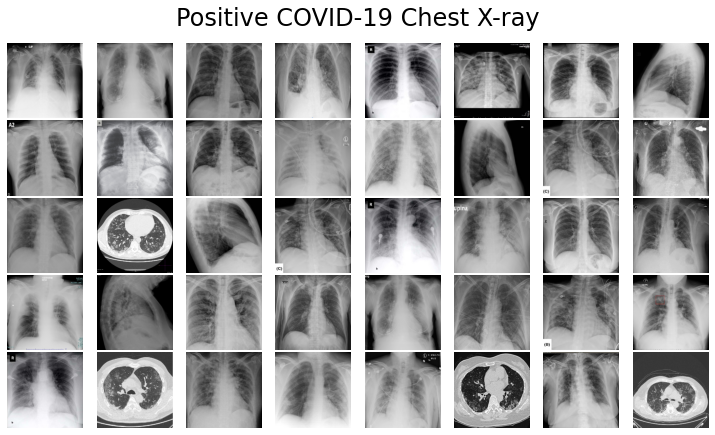

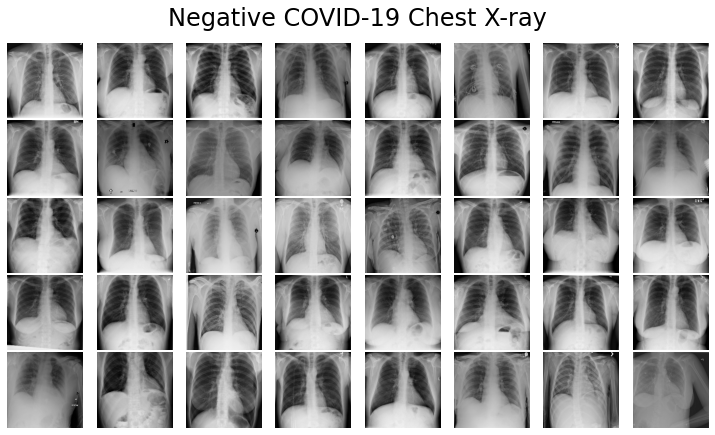

In [17]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [18]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

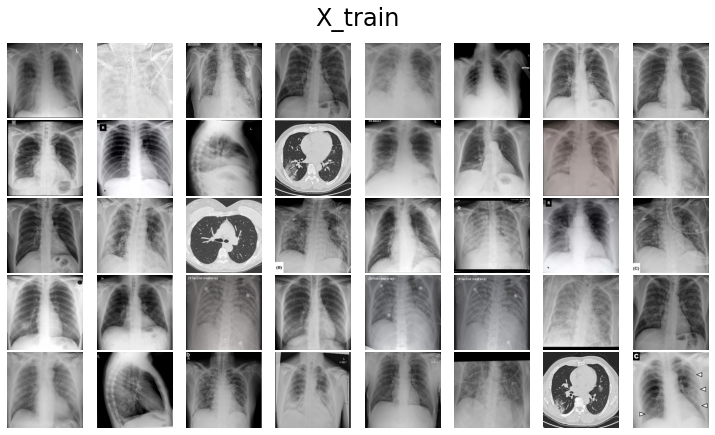

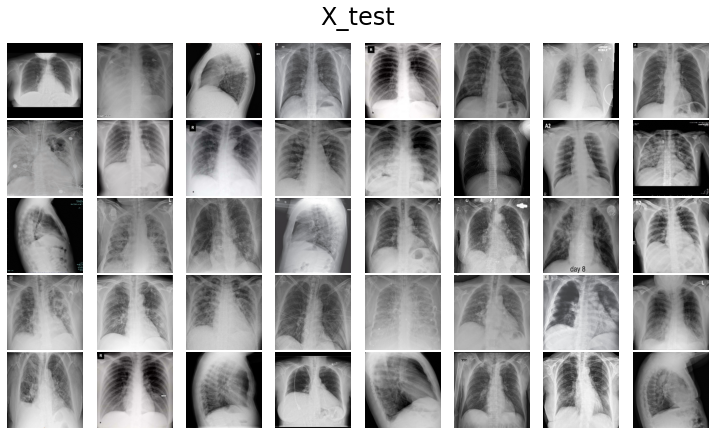

In [20]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

Building and visualizing our model extending inceptionv3

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Training the model

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 9s 387ms/step - loss: 2.3526 - accuracy: 0.7181 - val_loss: 0.8774 - val_accuracy: 0.7819
Epoch 2/500
24/23 [==============================] - 8s 325ms/step - loss: 1.3662 - accuracy: 0.7886 - val_loss: 0.7527 - val_accuracy: 0.8564
Epoch 3/500
24/23 [==============================] - 8s 321ms/step - loss: 0.9651 - accuracy: 0.8231 - val_loss: 1.4490 - val_accuracy: 0.7021
Epoch 4/500
24/23 [==============================] - 8s 324ms/step - loss: 0.7996 - accuracy: 0.8364 - val_loss: 1.6722 - val_accuracy: 0.7872
Epoch 5/500
24/23 [==============================] - 8s 328ms/step - loss: 1.2153 - accuracy: 0.8285 - val_loss: 1.2366 - val_accuracy: 0.7713
Epoch 6/500
24/23 [==============================] - 8s 332ms/step - loss: 1.1890 - accuracy: 0.8444 - val_loss: 0.5569 - val_accuracy: 0.8830
Epoch 7/500
24/23 [==============================] - 8s 329ms/step - loss: 1.4178 - accuracy: 0.8152 - val_loss: 0.6690 - val_accuracy: 0.8777

In [ ]:
model.save('inceptionv3_chest.h5')

model.save_weights('inceptionv3_chest.hdf5')

model = load_model('inceptionv3_chest.h5')

Making Predictions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

Visulaizing First 10 predictions

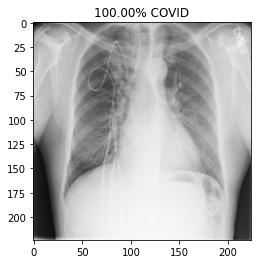

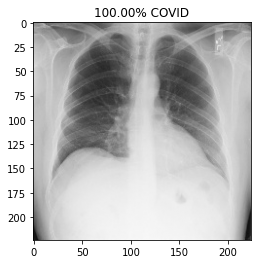

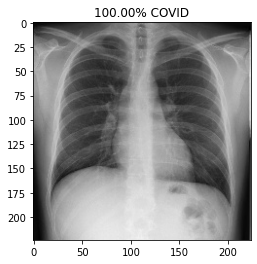

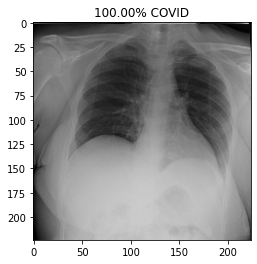

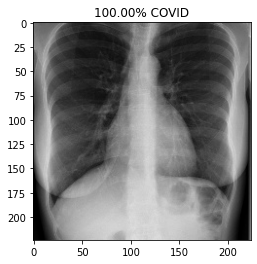

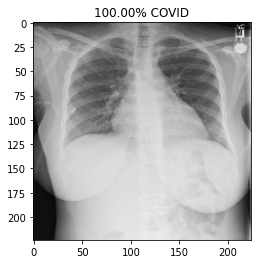

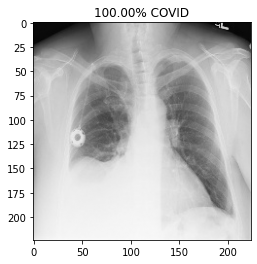

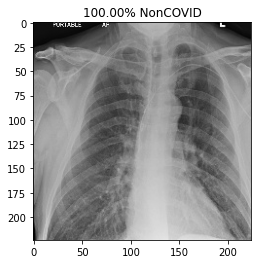

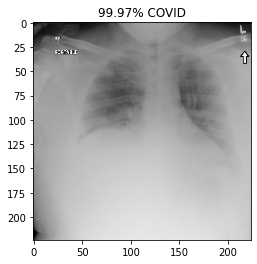

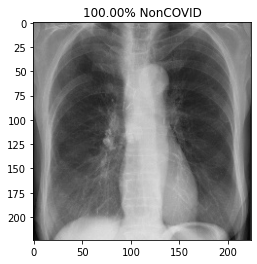

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Plot ROC Curve

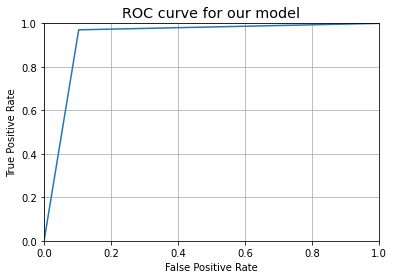

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plot confusion matrix

Confusion Matrix without Normalization


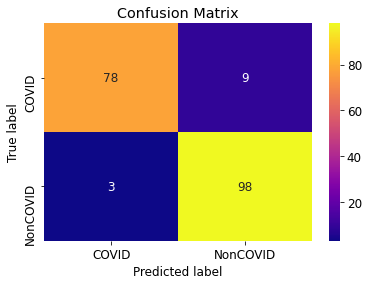

Confusion Matrix with Normalized Values


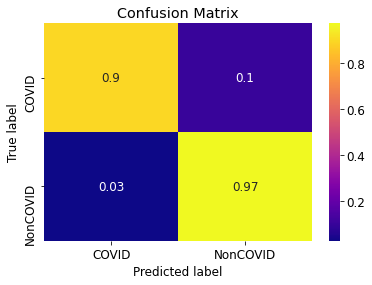

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

classification reports

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        87
           1       0.92      0.97      0.94       101

    accuracy                           0.94       188
   macro avg       0.94      0.93      0.94       188
weighted avg       0.94      0.94      0.94       188



Accuracy and loss plots

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()

Building Resnet Model and Visualizing

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 10s 406ms/step - loss: 2.8038 - accuracy: 0.5106 - val_loss: 1.9945 - val_accuracy: 0.5745
Epoch 2/500
24/23 [==============================] - 9s 370ms/step - loss: 1.3790 - accuracy: 0.5213 - val_loss: 0.8262 - val_accuracy: 0.5904
Epoch 3/500
24/23 [==============================] - 9s 369ms/step - loss: 0.9859 - accuracy: 0.5545 - val_loss: 0.6074 - val_accuracy: 0.6223
Epoch 4/500
24/23 [==============================] - 9s 366ms/step - loss: 1.0250 - accuracy: 0.5559 - val_loss: 0.7814 - val_accuracy: 0.5904
Epoch 5/500
24/23 [==============================] - 9s 367ms/step - loss: 1.0321 - accuracy: 0.5399 - val_loss: 0.5986 - val_accuracy: 0.6277
Epoch 6/500
24/23 [==============================] - 9s 369ms/step - loss: 0.9879 - accuracy: 0.5878 - val_loss: 0.5881 - val_accuracy: 0.6649
Epoch 7/500
24/23 [==============================] - 9s 369ms/step - loss: 0.9075 - accuracy: 0.5585 - val_loss: 0.8791 - val_accuracy: 0.590

In [ ]:
model.save('resnet_chest.h5')

model.save_weights('resnetweights_chest.hdf5')

model = load_model('resnet_chest.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

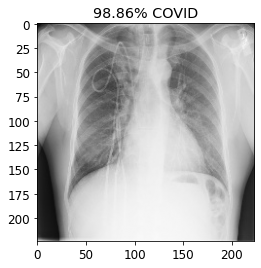

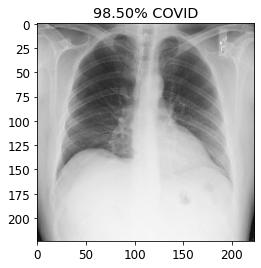

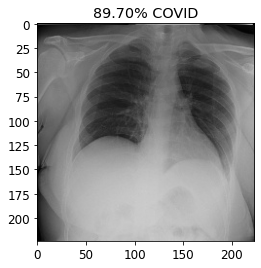

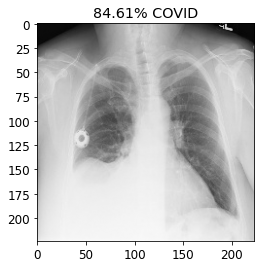

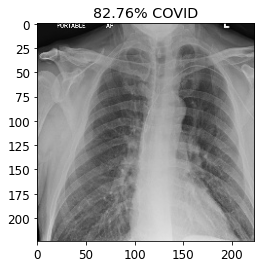

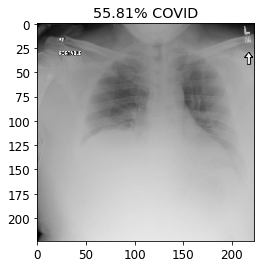

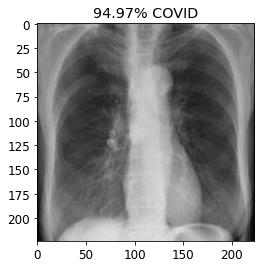

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

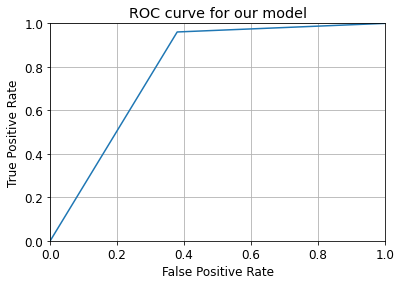

In [ ]:
#ROC curves
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


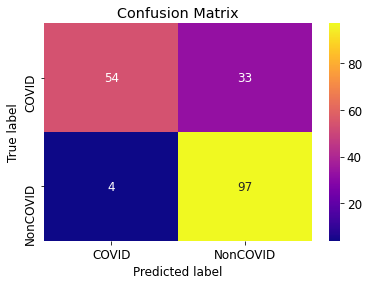

Confusion Matrix with Normalized Values


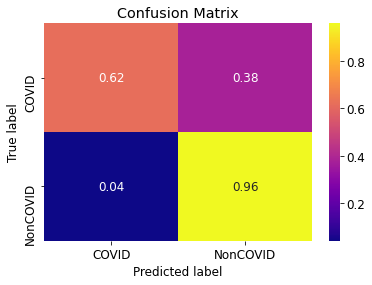

In [ ]:
#plot confusion matrix

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74        87
           1       0.75      0.96      0.84       101

    accuracy                           0.80       188
   macro avg       0.84      0.79      0.79       188
weighted avg       0.83      0.80      0.80       188



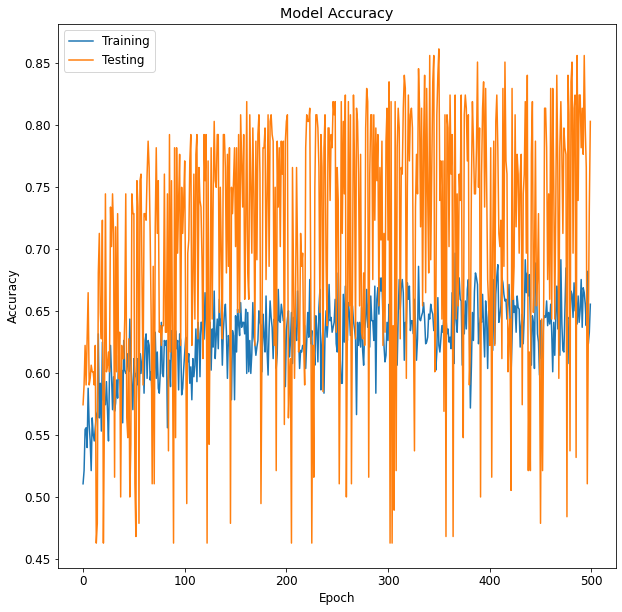

In [ ]:
#accuracy and loss plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()

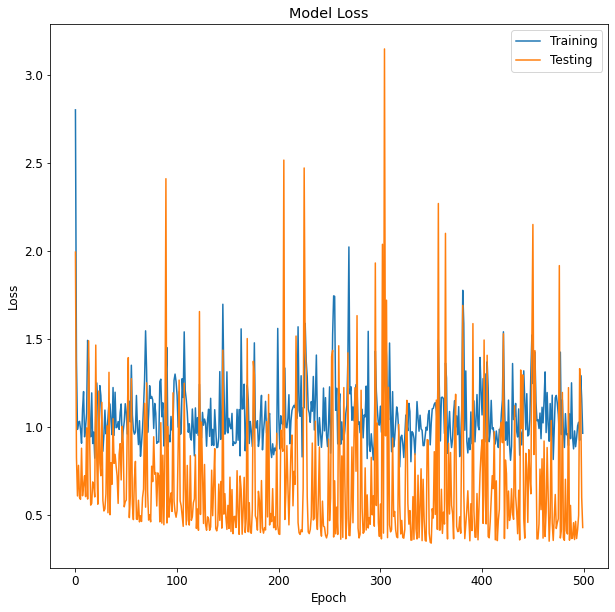

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()


Model building definition and visualization for VGG model

In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 12s 480ms/step - loss: 1.2304 - accuracy: 0.5638 - val_loss: 0.5493 - val_accuracy: 0.7872
Epoch 2/500
24/23 [==============================] - 10s 406ms/step - loss: 0.6139 - accuracy: 0.6848 - val_loss: 0.4115 - val_accuracy: 0.7979
Epoch 3/500
24/23 [==============================] - 10s 398ms/step - loss: 0.5525 - accuracy: 0.7221 - val_loss: 0.5533 - val_accuracy: 0.7660
Epoch 4/500
24/23 [==============================] - 10s 399ms/step - loss: 0.6178 - accuracy: 0.7088 - val_loss: 0.3861 - val_accuracy: 0.8138
Epoch 5/500
24/23 [==============================] - 10s 400ms/step - loss: 0.5167 - accuracy: 0.7686 - val_loss: 0.3762 - val_accuracy: 0.8085
Epoch 6/500
24/23 [==============================] - 10s 398ms/step - loss: 0.5148 - accuracy: 0.7899 - val_loss: 0.4145 - val_accuracy: 0.8404
Epoch 7/500
24/23 [==============================] - 10s 398ms/step - loss: 0.4129 - accuracy: 0.8059 - val_loss: 0.2963 - val_accuracy:

In [ ]:
model.save('vgg_chest.h5')

model.save_weights('vggweights_chest.hdf5')

model = load_model('vgg_chest.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

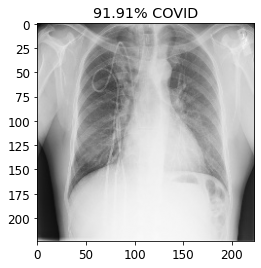

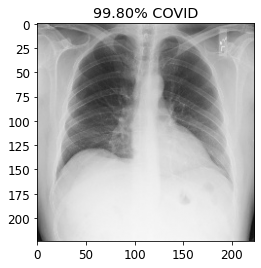

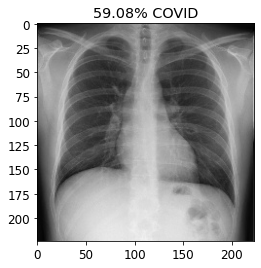

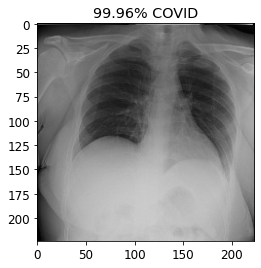

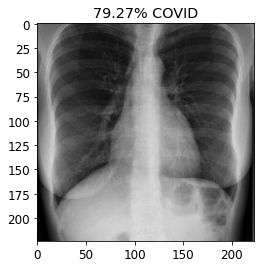

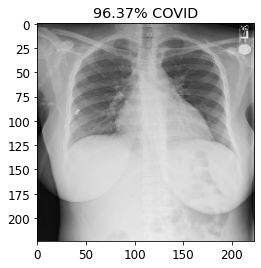

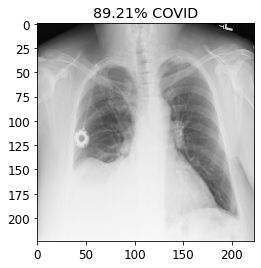

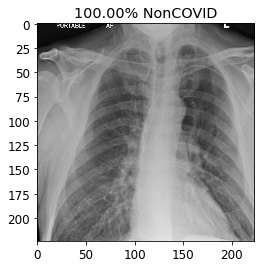

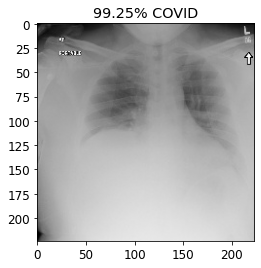

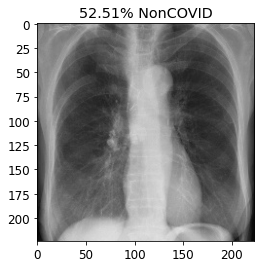

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

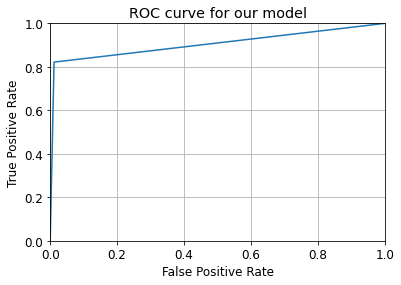

In [ ]:
#plot ROC Curves
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


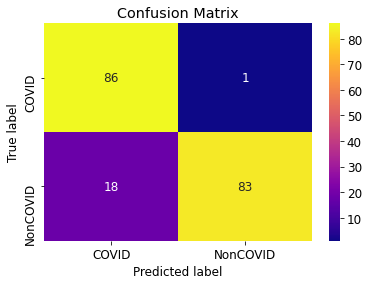

Confusion Matrix with Normalized Values


In [ ]:
#plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90        87
           1       0.99      0.82      0.90       101

    accuracy                           0.90       188
   macro avg       0.91      0.91      0.90       188
weighted avg       0.91      0.90      0.90       188



In [ ]:
#accuracy and loss plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

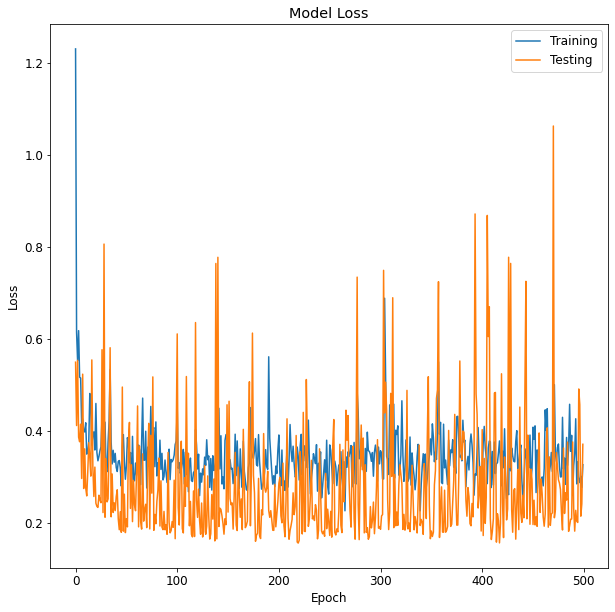

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()


Model building definition and visualization for xception model

In [21]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [22]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [23]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [24]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 11s 448ms/step - loss: 1.4273 - accuracy: 0.7606 - val_loss: 0.6939 - val_accuracy: 0.8457
Epoch 2/500
24/23 [==============================] - 10s 396ms/step - loss: 0.8713 - accuracy: 0.7992 - val_loss: 0.6152 - val_accuracy: 0.8404
Epoch 3/500
24/23 [==============================] - 10s 402ms/step - loss: 0.9373 - accuracy: 0.8138 - val_loss: 0.5868 - val_accuracy: 0.8457
Epoch 4/500
24/23 [==============================] - 10s 405ms/step - loss: 0.6321 - accuracy: 0.8564 - val_loss: 0.5287 - val_accuracy: 0.8830
Epoch 5/500
24/23 [==============================] - 10s 396ms/step - loss: 0.5428 - accuracy: 0.8684 - val_loss: 0.8931 - val_accuracy: 0.8191
Epoch 6/500
24/23 [==============================] - 10s 396ms/step - loss: 0.5276 - accuracy: 0.8830 - val_loss: 0.5272 - val_accuracy: 0.8777
Epoch 7/500
24/23 [==============================] - 10s 401ms/step - loss: 0.5776 - accuracy: 0.8936 - val_loss: 0.4074 - val_accuracy:

In [25]:
model.save('xception_chest.h5')

model.save_weights('xceptionweights_chest.hdf5')

model = load_model('xception_chest.h5')

In [26]:
y_pred = model.predict(X_test, batch_size=batch_size)

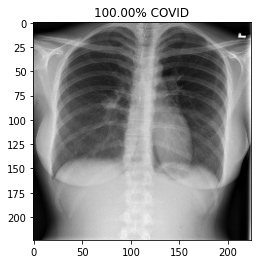

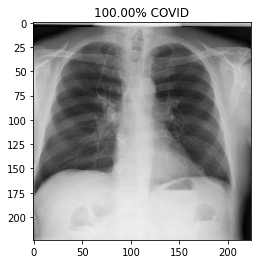

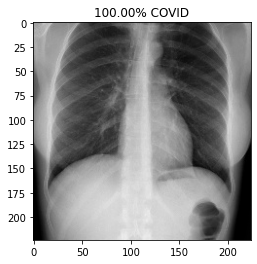

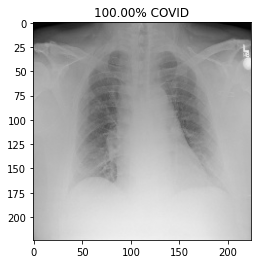

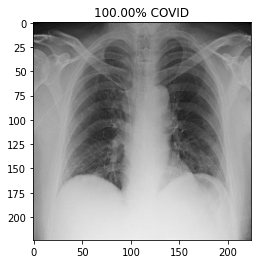

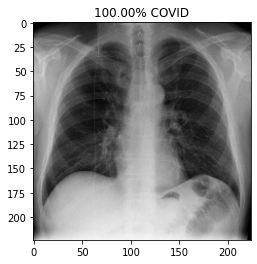

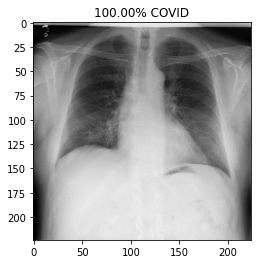

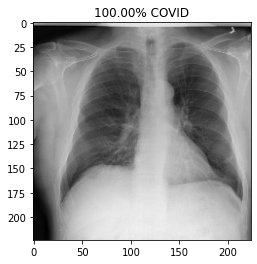

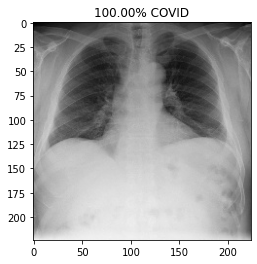

In [27]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [28]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

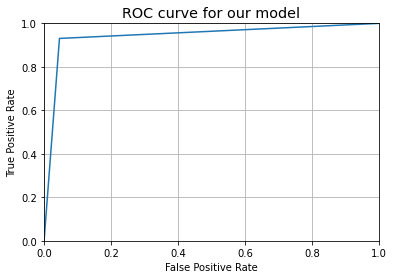

In [29]:
#plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


Confusion Matrix with Normalized Values


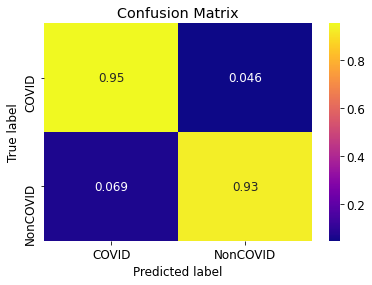

In [30]:
#plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [31]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94        87
           1       0.96      0.93      0.94       101

    accuracy                           0.94       188
   macro avg       0.94      0.94      0.94       188
weighted avg       0.94      0.94      0.94       188



In [32]:
#accuracy and loss figures
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_accuracy.png')
plt.show()

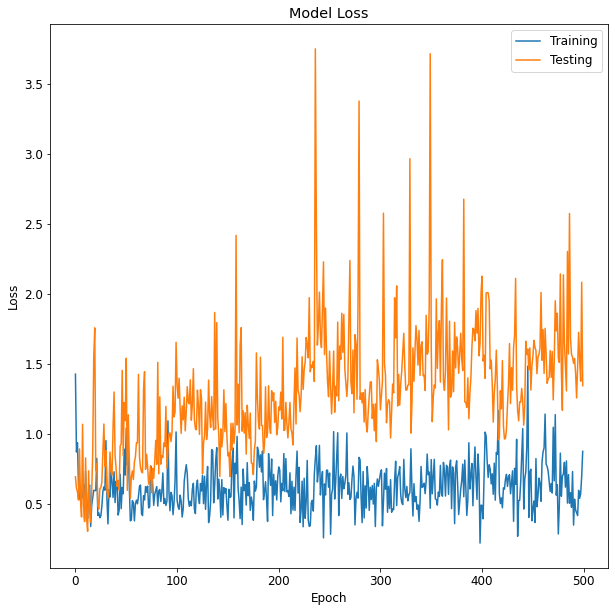

In [33]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_loss.png')
plt.show()